## MultiHeadAttention using attention matrix for delay estimation

In [3]:
import tensorflow as tf
from tensorflow.keras import layers,models, regularizers
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [99]:
class CNN(tf.keras.Model):
    def __init__(self, type="flows", l2_reg=0.01):
        super(CNN, self).__init__()
        self.type = type
        if type == "images_flows":
            dim = 6
        elif type == "cross_flows":
            dim = 9
        else:
            dim = 3
        self.cnn = models.Sequential()

        reg = regularizers.l2(l2_reg)

        self.cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, dim), kernel_regularizer=reg))
        self.cnn.add(layers.MaxPooling2D((3, 3)))

        self.cnn.add(layers.Conv2D(48, (3, 3), activation='relu', kernel_regularizer=reg))
        self.cnn.add(layers.MaxPooling2D((2, 2)))

        self.cnn.add(layers.Conv2D(48, (3, 3), activation='relu', kernel_regularizer=reg))
        self.cnn.add(layers.MaxPooling2D((2, 2)))

        self.cnn.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=reg))
        self.cnn.add(layers.MaxPooling2D((2, 2)))

        self.cnn.add(layers.GlobalAveragePooling2D())
        self.cnn.add(layers.Dense(48, activation='relu', kernel_regularizer=reg))

    def call(self, inputs):
        return self.cnn(inputs)
    
Extractor = CNN()

random_images = np.random.random((20, 224, 224, 3)) * 255
random_images = random_images.astype('float32')/ 255.0
left_imgs = tf.convert_to_tensor(random_images, dtype=tf.float32)

random_images = np.random.random((20, 224, 224, 3)) * 255
random_images = random_images.astype('float32')/ 255.0
right_imgs = tf.convert_to_tensor(random_images, dtype=tf.float32)

left_features = Extractor(left_imgs)
right_features = Extractor(right_imgs)
left_features = tf.expand_dims(left_features,axis=0)  #[batch_size, query_seq_length, feature_dim]
right_features = tf.expand_dims(right_features,axis=0) # [batch_size, key_seq_length, feature_dim]

print("left_features:",left_features.shape) #(1, 20, 48)

left_features: (1, 20, 48)


In [100]:
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention

query, key, value = left_features, right_features, right_features
attention_layer = MultiHeadAttention(num_heads=8, key_dim=64)
output, attention_scores = attention_layer(query, key, value, return_attention_scores=True)
similarity_matrix = tf.reduce_mean(attention_scores, axis=1)

print(attention_scores.shape)   # (1, 8, 20, 20)
print(similarity_matrix.shape)  # (1, 20, 20)

matrix = similarity_matrix[0]

# Calculate the mean of the diagonals and find the diagonal with the maximum mean
diagonal_means = []
for offset in range(-19, 20):
    diagonal = np.diagonal(matrix, offset=offset)
    if diagonal.size > 0:
        mean_value = np.mean(diagonal)
        diagonal_means.append((offset, mean_value))

# Find the diagonal with the maximum mean
max_mean = max(diagonal_means, key=lambda x: x[1])
max_offset, _ = max_mean

print(max_offset)

(1, 8, 20, 20)
(1, 20, 20)
-17


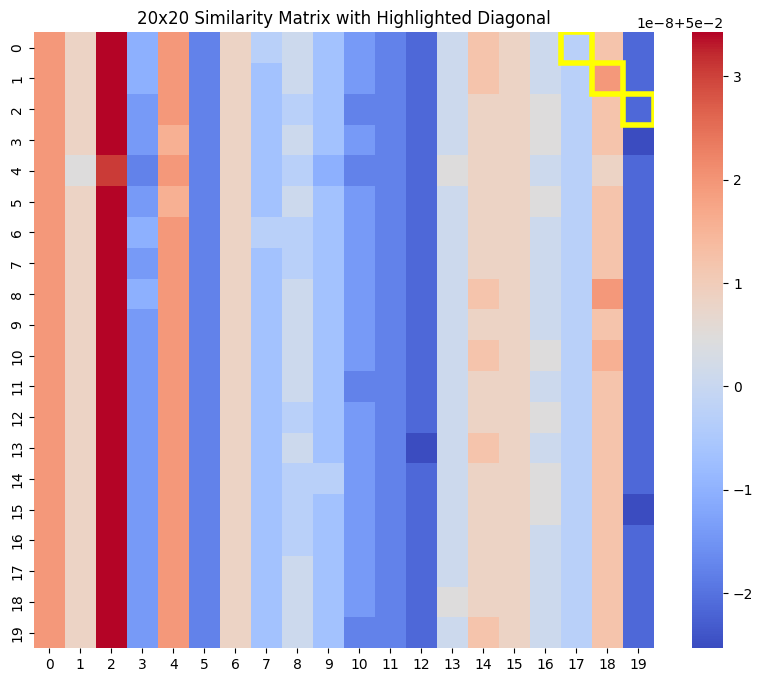

In [101]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(matrix, annot=False, cmap='coolwarm', cbar=True)

# Define the style for the yellow box
box_color = 'yellow'
box_linewidth = 4

# Add a yellow box to highlight the diagonal with the maximum mean
if max_offset >= 0:
    for i in range(min(20 - max_offset, 20)):
        ax.add_patch(Rectangle((i, i + max_offset), 1, 1, fill=False, edgecolor=box_color, lw=box_linewidth))
else:
    for i in range(min(20, 20 + max_offset)):
        ax.add_patch(Rectangle((i - max_offset, i), 1, 1, fill=False, edgecolor=box_color, lw=box_linewidth))

plt.title('20x20 Similarity Matrix with Highlighted Diagonal')
plt.show()

## Seem like if the output is attention_scores,the gradient can not be back propagate.

In [97]:
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, Input
from tensorflow.keras.models import Model
import numpy as np

class MultiHeadAttentionModel:
    def __init__(self, num_heads, key_dim, sequence_length, input_dim):
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.input_dim = input_dim
        self.sequence_length = sequence_length
        self.model = self.build_model()

    def build_model(self):
        query_input = Input(shape=(self.sequence_length, self.input_dim))
        key_input = Input(shape=(self.sequence_length, self.input_dim))
        value_input = Input(shape=(self.sequence_length, self.input_dim))

        # MultiHeadAttention
        attention_layer = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.key_dim)
        attention_output, attention_scores = attention_layer(query=query_input, key=key_input, value=value_input, return_attention_scores=True)

        model = Model(inputs=[query_input, key_input, value_input], outputs=attention_scores)
        
        return model

    def compile_model(self, optimizer='adam'):
        self.model.compile(optimizer=optimizer, loss=self.loss_diagonal)
    
#     def loss(self, y_true, attention_scores):
#         return tf.reduce_mean(tf.square(y_true - attention_scores))
    
    def loss_diagonal(self, y_true, attention_scores):
        similarity_matrix = tf.reduce_mean(attention_scores, axis=1)

        def calculate_max_offset(matrix):
            diagonal_means = []
            for offset in range(-self.sequence_length + 1, self.sequence_length):
                diagonal = tf.linalg.diag_part(matrix, k=offset)
                mean_value = tf.cond(tf.size(diagonal) > 0, lambda: tf.reduce_mean(diagonal), lambda: tf.constant(0.0))
                diagonal_means.append(mean_value)
            diagonal_means = tf.stack(diagonal_means)
            max_offset = tf.argmax(diagonal_means)
            return tf.cast(max_offset, tf.float32)

        max_offsets = tf.map_fn(calculate_max_offset, similarity_matrix, fn_output_signature=tf.float32)

        return tf.reduce_mean(tf.square(y_true - max_offsets))
        
    def train_model(self, X_train, y_train, epochs=10, batch_size=32):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    def summary(self):
        self.model.summary()

if __name__ == "__main__":
    num_heads = 8
    key_dim = 64
    sequence_length = 20
    input_dim = 48

    mha_model = MultiHeadAttentionModel(num_heads, key_dim, sequence_length, input_dim)
    mha_model.compile_model()

    mha_model.summary()

    query_data = np.random.random((32, sequence_length, input_dim))
    key_data = np.random.random((32, sequence_length, input_dim))
    value_data = key_data
    y_train = np.random.random((32,))
#     y_train = np.random.random((32,8,20,20))

    X_train = [query_data, key_data, value_data]
    mha_model.train_model(X_train, y_train)


Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_100 (InputLayer)         [(None, 20, 64)]     0           []                               
                                                                                                  
 input_101 (InputLayer)         [(None, 20, 64)]     0           []                               
                                                                                                  
 input_102 (InputLayer)         [(None, 20, 64)]     0           []                               
                                                                                                  
 multi_head_attention_79 (Multi  ((None, 20, 64),    132672      ['input_100[0][0]',              
 HeadAttention)                  (None, 8, 20, 20))               'input_101[0][0]',       

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, Input
from tensorflow.keras.models import Model
import numpy as np

# Custom MultiHeadAttention layer that only returns attention_scores
class CustomMultiHeadAttention(MultiHeadAttention):
    def call(self, query, value, key=None, attention_mask=None, **kwargs):
        # Call the original MultiHeadAttention call function
        _, attention_scores = super().call(
            query=query,
            value=value,
            key=key,
            attention_mask=attention_mask,
            return_attention_scores=True,  # Ensure to return attention_scores
            **kwargs
        )
        return attention_scores  # Return only the attention_scores

# Build the model
input_layer = Input(shape=(5, 64))
attention_scores = CustomMultiHeadAttention(num_heads=8, key_dim=64)(input_layer, input_layer)
model = Model(inputs=input_layer, outputs=attention_scores)

# Compile the model using categorical_crossentropy as the loss function, suitable for probability distribution outputs
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Generate random data as input and target output
x_train = np.random.random((100, 5, 64))
y_train = np.random.random((100, 8, 5, 5))  # Note: y_train shape should match the expected output shape from the model

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=10)

# Use GradientTape to check gradient flow
with tf.GradientTape() as tape:
    inputs = tf.convert_to_tensor(x_train, dtype=tf.float32)
    tape.watch(inputs)
    predictions = model(inputs)
    loss = tf.keras.losses.categorical_crossentropy(y_train, predictions)

# gradients = tape.gradient(loss, model.trainable_variables)
# print("Gradients on trainable variables:", gradients)


2024-08-12 19:42:44.037221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 19:42:44.893861: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 19:42:46.397537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:/usr/include/opencv4
2024-08-12 19:42:46.397661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvi

Epoch 1/10
10/10 [==============================] - 2s 3ms/step - loss: 4.0058
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 4.0250
Epoch 3/10
10/10 [==============================] - 0s 2ms/step - loss: 4.1764
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 4.7556
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 6.0872
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 8.4882
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 12.0002
Epoch 8/10
10/10 [==============================] - 0s 2ms/step - loss: 16.5257
Epoch 9/10
10/10 [==============================] - 0s 2ms/step - loss: 21.9373
Epoch 10/10
10/10 [==============================] - 0s 2ms/step - loss: 28.4991


## MultiHeadAttention predicting delay token

In [66]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers, losses
import numpy as np

class CNN(tf.keras.Model):
    def __init__(self, type="flows", l2_reg=0.01):
        super(CNN, self).__init__()
        self.type = type
        if type == "images_flows":
            dim = 6
        elif type == "cross_flows":
            dim = 9
        else:
            dim = 3
        print("dim: ", dim)
        self.cnn = models.Sequential()

        reg = regularizers.l2(l2_reg)

        self.cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, dim), kernel_regularizer=reg))
        self.cnn.add(layers.MaxPooling2D((3, 3)))

        self.cnn.add(layers.Conv2D(48, (3, 3), activation='relu', kernel_regularizer=reg))
        self.cnn.add(layers.MaxPooling2D((2, 2)))

        self.cnn.add(layers.Conv2D(48, (3, 3), activation='relu', kernel_regularizer=reg))
        self.cnn.add(layers.MaxPooling2D((2, 2)))

        self.cnn.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=reg))
        self.cnn.add(layers.MaxPooling2D((2, 2)))

        self.cnn.add(layers.GlobalAveragePooling2D())
        self.cnn.add(layers.Dense(48, activation='relu', kernel_regularizer=reg))

    def call(self, inputs):
        return self.cnn(inputs)

class MLPHead(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, num_classes, dropout_rate=0.1):
        super(MLPHead, self).__init__()
        self.dense1 = layers.Dense(hidden_dim, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.dense2 = layers.Dense(num_classes)
        self.softmax = layers.Softmax()

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dropout(x, training=training)
        x = self.dense2(x)
        return self.softmax(x)

class TransformerModel(tf.keras.Model):
    def __init__(self, num_heads, dff, num_layers, hidden_dim, num_classes, rate=0.1):
        super(TransformerModel, self).__init__()
        self.num_layers = num_layers
        self.class_token = self.add_weight("class_token", shape=[1, 1, 48], initializer="random_normal")
        self.encoder_layers = [layers.MultiHeadAttention(num_heads=num_heads, key_dim=48) for _ in range(num_layers)]
        self.ffn_layers = [self.point_wise_feed_forward_network(48, dff) for _ in range(num_layers)]
        self.dropout_layers = [layers.Dropout(rate) for _ in range(num_layers)]
        self.mlp_head = MLPHead(hidden_dim, num_classes, dropout_rate=rate)

    def point_wise_feed_forward_network(self, d_model, dff):
        return tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])
    
    def call(self, inputs, training=True):
        query = inputs['query']
        context = inputs['context']
        batch_size = tf.shape(query)[0]
        class_token = tf.broadcast_to(self.class_token, [batch_size, 1, 48])
        for i in range(self.num_layers):
            class_token = self.encoder_layers[i](query=class_token, value=context, key=context)
            class_token = self.ffn_layers[i](class_token)
            class_token = self.dropout_layers[i](class_token, training=training)
        class_token_output = tf.squeeze(class_token, axis=1)  # Remove the sequence dimension
        output = self.mlp_head(class_token_output, training=training)
        return output

# Instantiate the CNN model
Extractor = CNN()

# Generate random images
random_images = np.random.random((20, 224, 224, 3)) * 255
random_images = random_images.astype('float32') / 255.0
left_imgs = tf.convert_to_tensor(random_images, dtype=tf.float32)

random_images = np.random.random((20, 224, 224, 3)) * 255
random_images = random_images.astype('float32') / 255.0
right_imgs = tf.convert_to_tensor(random_images, dtype=tf.float32)

# Extract features
left_features = Extractor(left_imgs)
right_features = Extractor(right_imgs)

# Reshape features to [num_samples, seq_length, feature_dim]
left_features = tf.reshape(left_features, [1, 20, 48])
right_features = tf.reshape(right_features, [1, 20, 48])

# Prepare dummy labels for training
num_classes = 40
dummy_labels = tf.random.uniform([1], maxval=num_classes, dtype=tf.int32)  # Single random label

# Define the dataset
dataset = tf.data.Dataset.from_tensor_slices(({'query': left_features, 'context': right_features}, dummy_labels))
dataset = dataset.repeat().batch(1)  # Repeat dataset for training and batch size of 1

# Instantiate the Transformer model
hidden_dim = 512  # Example hidden dimension for MLP head
transformer = TransformerModel(num_heads=8, dff=128, num_layers=2, hidden_dim=hidden_dim, num_classes=num_classes)

# Define loss function, optimizer, and metrics
loss_fn = losses.SparseCategoricalCrossentropy()
optimizer = optimizers.Adam()

# Compile the model
transformer.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Train the model
transformer.fit(dataset, steps_per_epoch=10, epochs=10)


dim:  3
Epoch 1/10
10/10 [==============================] - 1s 5ms/step - loss: 3.3770 - accuracy: 0.9000
Epoch 2/10
10/10 [==============================] - 0s 5ms/step - loss: 0.8023 - accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 5.6385e-06 - accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
10/10 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
10/10 [==============================] - 0s 5ms/step - loss: 0.0000e+0

In [67]:
transformer.summary()

Model: "transformer_model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 multi_head_attention_56 (Mu  multiple                 74928     
 ltiHeadAttention)                                               
                                                                 
 multi_head_attention_57 (Mu  multiple                 74928     
 ltiHeadAttention)                                               
                                                                 
 sequential_58 (Sequential)  (None, 1, 48)             12464     
                                                                 
 sequential_59 (Sequential)  (None, 1, 48)             12464     
                                                                 
 dropout_84 (Dropout)        multiple                  0         
                                                                 
 dropout_85 (Dropout)        multiple         

In [71]:
# Prepare dummy data for testing
test_random_images = np.random.random((20, 224, 224, 3)) * 255
test_random_images = test_random_images.astype('float32') / 255.0
test_left_imgs = tf.convert_to_tensor(test_random_images, dtype=tf.float32)

test_random_images = np.random.random((20, 224, 224, 3)) * 255
test_random_images = test_random_images.astype('float32') / 255.0
test_right_imgs = tf.convert_to_tensor(test_random_images, dtype=tf.float32)

# Extract features for testing
test_left_features = Extractor(test_left_imgs)
test_right_features = Extractor(test_right_imgs)

# Reshape test features to [num_samples, seq_length, feature_dim]
test_left_features = tf.reshape(test_left_features, [1, 20, 48])
test_right_features = tf.reshape(test_right_features, [1, 20, 48])

# Prepare dummy labels for testing
test_dummy_labels = tf.random.uniform([1], maxval=num_classes, dtype=tf.int32)  # Single random label

# Define the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(({'query': test_left_features, 'context': test_right_features}, test_dummy_labels))
test_dataset = test_dataset.batch(1)  # Batch size of 1 for testing

# Evaluate the model on the test dataset
test_loss, test_accuracy = transformer.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Predict new data
num_new_samples = 5
new_random_images = np.random.random((num_new_samples*20, 224, 224, 3)) * 255
new_random_images = new_random_images.astype('float32') / 255.0
new_left_imgs = tf.convert_to_tensor(new_random_images, dtype=tf.float32)

new_random_images = np.random.random((num_new_samples*20, 224, 224, 3)) * 255
new_random_images = new_random_images.astype('float32') / 255.0
new_right_imgs = tf.convert_to_tensor(new_random_images, dtype=tf.float32)

# Extract features for new data
new_left_features = Extractor(new_left_imgs)
new_right_features = Extractor(new_right_imgs)
print(new_left_features.shape)

# Reshape new features to [num_samples, seq_length, feature_dim]
new_left_features = tf.reshape(new_left_features, [num_new_samples, 20, 48])
new_right_features = tf.reshape(new_right_features, [num_new_samples, 20, 48])

# Predict new data
predictions = transformer.predict({'query': new_left_features, 'context': new_right_features})
print(predictions[0])
# predicted_classes = tf.argmax(predictions, axis=-1)
# print(f'Predicted classes: {predicted_classes.numpy()}')

1/1 [==============================] - 0s 10ms/step - loss: 56.6057 - accuracy: 0.0000e+00
Test Loss: 56.60567855834961
Test Accuracy: 0.0
(100, 48)
1/1 [==============================] - 0s 16ms/step
[8.7303086e-24 7.5729631e-25 1.7103794e-25 2.8701448e-24 4.6874052e-24
 4.4761795e-26 1.9642023e-24 3.7596297e-25 1.9204243e-22 4.6879523e-27
 2.6765143e-24 9.7083155e-24 2.8278255e-24 2.5260622e-24 6.4930039e-27
 2.8680530e-25 1.2352159e-24 6.6704871e-24 1.0655454e-25 2.7292507e-25
 1.5143536e-24 1.2450232e-23 5.3253571e-26 1.5185369e-23 2.6037452e-23
 1.0000000e+00 7.3104031e-25 4.6439576e-25 8.1066434e-26 5.5899847e-25
 5.5556121e-24 1.1635327e-26 2.4411495e-27 2.2637604e-24 1.5466726e-26
 3.5405036e-26 2.5290222e-24 1.0497220e-25 1.7972824e-25 2.4954520e-24]


## Training in real data

In [7]:
import numpy as np
import pandas as pd

# extracted feature
trainDS = np.load("/home/jireh/MT/video_sync_v1/trash/featureData.npy",allow_pickle=True)
print(trainDS[0][0].shape)

# Convert to a pandas DataFrame (optional, for better visualization)
df = pd.DataFrame(trainDS)
# Display the first few rows
df.head()

(20, 48)


,0,1,2,3,4
0,"[[0.0, 0.0, 0.0, 0.69037163, 0.0, 0.0, 0.0, 0....","[[0.0, 0.0, 0.0, 1.0563793, 0.0, 0.0, 0.0, 0.8...",1963,1983,20
1,"[[0.0, 0.0, 0.0, 0.8872391, 0.0, 0.0, 0.0, 1.2...","[[0.0, 0.0, 0.0, 0.37041047, 0.0, 0.0, 0.0, 0....",8545,8554,9
2,"[[0.0, 0.0, 0.0, 1.340517, 0.0, 0.0, 0.0, 0.64...","[[0.0, 0.0, 0.0, 1.8816519, 0.0, 0.0, 0.0, 0.4...",2322,2326,4
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3974726...","[[0.0, 0.0, 0.0, 0.16040325, 0.0, 0.0, 0.0, 0....",7385,7398,13
4,"[[0.0, 0.0, 0.0, 1.4631886, 0.0, 0.0, 0.0, 0.4...","[[0.0, 0.0, 0.0, 1.233583, 0.0, 0.0, 0.0, 0.16...",7953,7941,-12


In [75]:
from tensorflow.keras.utils import to_categorical

class MLPHead(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, num_classes, dropout_rate=0.1):
        super(MLPHead, self).__init__()
        self.dense1 = layers.Dense(hidden_dim, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.dense2 = layers.Dense(num_classes)
        self.softmax = layers.Softmax()

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dropout(x, training=training)
        x = self.dense2(x)
        return self.softmax(x)

class TransformerModel(tf.keras.Model):
    def __init__(self, num_heads, dff, num_layers, hidden_dim, num_classes, rate=0.1):
        super(TransformerModel, self).__init__()
        self.num_layers = num_layers
        self.class_token = self.add_weight("class_token", shape=[1, 1, 48], initializer="random_normal")
        self.encoder_layers = [layers.MultiHeadAttention(num_heads=num_heads, key_dim=48) for _ in range(num_layers)]
        self.ffn_layers = [self.point_wise_feed_forward_network(48, dff) for _ in range(num_layers)]
        self.dropout_layers = [layers.Dropout(rate) for _ in range(num_layers)]
        self.mlp_head = MLPHead(hidden_dim, num_classes, dropout_rate=rate)

    def point_wise_feed_forward_network(self, d_model, dff):
        return tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])
    
    def call(self, inputs, training=True):
        query = inputs['query']
        context = inputs['context']
        batch_size = tf.shape(query)[0]
        class_token = tf.broadcast_to(self.class_token, [batch_size, 1, 48])
        for i in range(self.num_layers):
            class_token = self.encoder_layers[i](query=class_token, value=context, key=context)
            class_token = self.ffn_layers[i](class_token)
            class_token = self.dropout_layers[i](class_token, training=training)
        class_token_output = tf.squeeze(class_token, axis=1)  # Remove the sequence dimension
        output = self.mlp_head(class_token_output, training=training)
        return output


In [76]:
left_features = trainDS[:, 0].tolist()
right_features = trainDS[:, 1].tolist()
y = trainDS[:, 4].tolist()

left_features = np.array(left_features)
right_features = np.array(right_features)
y = np.array(y)

left_features = tf.convert_to_tensor(left_features, dtype=tf.float32)
right_features = tf.convert_to_tensor(right_features, dtype=tf.float32)
y = to_categorical(y,num_classes=40)

size = int(len(y) * 0.8)  # 80% of the data for training

# left_features_train, left_features_val = left_features[:size], left_features[size:]
# right_features_train, right_features_val = right_features[:size], right_features[size:]
# y_train, y_val = y[:size], y[size:]

# Define the dataset
dataset = tf.data.Dataset.from_tensor_slices(({'query': left_features, 'context': right_features}, y))
dataset = dataset.repeat().batch(256)  

# Instantiate the Transformer model
hidden_dim = 512  # Example hidden dimension for MLP head
transformer = TransformerModel(num_heads=8, dff=128, num_layers=2, hidden_dim=hidden_dim, num_classes=num_classes)

optimizer = optimizers.Adam(learning_rate=1e-5)

# Compile the model
transformer.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
transformer.fit(dataset, steps_per_epoch=10, epochs=10)

Epoch 1/10
10/10 [==============================] - 1s 11ms/step - loss: 3.6896 - accuracy: 0.0273
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 3.6895 - accuracy: 0.0238
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 3.6894 - accuracy: 0.0277
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 3.6897 - accuracy: 0.0191
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 3.6899 - accuracy: 0.0285
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 3.6896 - accuracy: 0.0227
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 3.6894 - accuracy: 0.0227
Epoch 8/10
10/10 [==============================] - 0s 11ms/step - loss: 3.6901 - accuracy: 0.0223
Epoch 9/10
10/10 [==============================] - 0s 11ms/step - loss: 3.6891 - accuracy: 0.0223
Epoch 10/10
10/10 [==============================] - 0s 11ms/step - loss: 3.6898 - accuracy: 0.0230


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, mean_absolute_error

class TransformerDelay:
    def __init__(self, num_heads=8, dff=128, num_layers=2, hidden_dim=512, num_classes=40, rate=0.1):
        # Initialize the TransformerDelay class with default or custom parameters
        self.model = self.build_model(num_heads, dff, num_layers, hidden_dim, num_classes, rate)
        self.model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

    def build_model(self, num_heads, dff, num_layers, hidden_dim, num_classes, rate):
        # Inner class to define the MLP Head
        class MLPHead(tf.keras.layers.Layer):
            def __init__(self, hidden_dim, num_classes, dropout_rate=0.1):
                super(MLPHead, self).__init__()
                self.dense1 = layers.Dense(hidden_dim, activation='relu')
                self.dropout = layers.Dropout(dropout_rate)
                self.dense2 = layers.Dense(num_classes)
                self.softmax = layers.Softmax()

            def call(self, inputs, training=False):
                # Define the forward pass for the MLP Head
                x = self.dense1(inputs)
                x = self.dropout(x, training=training)
                x = self.dense2(x)
                return self.softmax(x)

        # Inner class to define the Transformer Model
        class TransformerModel(tf.keras.Model):
            def __init__(self, num_heads, dff, num_layers, hidden_dim, num_classes, rate=0.1):
                super(TransformerModel, self).__init__()
                self.num_layers = num_layers
                self.class_token = self.add_weight("class_token", shape=[1, 1, 48], initializer="random_normal")
                self.encoder_layers = [layers.MultiHeadAttention(num_heads=num_heads, key_dim=48) for _ in range(num_layers)]
                self.ffn_layers = [self.point_wise_feed_forward_network(48, dff) for _ in range(num_layers)]
                self.dropout_layers = [layers.Dropout(rate) for _ in range(num_layers)]
                self.mlp_head = MLPHead(hidden_dim, num_classes, dropout_rate=rate)

            def point_wise_feed_forward_network(self, d_model, dff):
                # Define the point-wise feed forward network used in the Transformer layers
                return tf.keras.Sequential([
                    layers.Dense(dff, activation='relu'),
                    layers.Dense(d_model)
                ])

            def call(self, inputs, training=True):
                # Define the forward pass for the Transformer Model
                query = inputs['query']
                context = inputs['context']
                batch_size = tf.shape(query)[0]
                class_token = tf.broadcast_to(self.class_token, [batch_size, 1, 48])
                for i in range(self.num_layers):
                    class_token = self.encoder_layers[i](query=class_token, value=context, key=context)
                    class_token = self.ffn_layers[i](class_token)
                    class_token = self.dropout_layers[i](class_token, training=training)
                class_token_output = tf.squeeze(class_token, axis=1)
                output = self.mlp_head(class_token_output, training=training)
                return output

        # Return the built TransformerModel
        return TransformerModel(num_heads, dff, num_layers, hidden_dim, num_classes, rate)

    def train(self, pathSimilarityVectorsArray: str, loadweight="", model_name=""):
        # Load the training dataset
        trainDS = np.load(fr"{pathSimilarityVectorsArray}", allow_pickle=True)
        left_features = trainDS[:, 0].tolist()
        right_features = trainDS[:, 1].tolist()
        y = trainDS[:, 4].tolist()

        # Convert data to the appropriate format
        left_features = np.array(left_features)
        right_features = np.array(right_features)
        y = np.array(y)

        left_features = tf.convert_to_tensor(left_features, dtype=tf.float32)
        right_features = tf.convert_to_tensor(right_features, dtype=tf.float32)
        y = to_categorical(y, num_classes=40)

        # Split the dataset into training and validation sets
        size = int(len(y) * 0.8)
        left_features_train, left_features_val = left_features[:size], left_features[size:]
        right_features_train, right_features_val = right_features[:size], right_features[size:]
        y_train, y_val = y[:size], y[size:]

        # Create the TensorFlow dataset for training
        dataset = tf.data.Dataset.from_tensor_slices(
            ({'query': left_features_train, 'context': right_features_train}, y_train)
        ).repeat().batch(256)

        # Define the directory for saving model weights
        weightsPath = fr"model/TransformerDelay/weight/{model_name}"
        if not os.path.exists(weightsPath):
            os.makedirs(weightsPath)

        # Define early stopping callback and model checkpoint callback
        best_metrics_callback = callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
        checkPoint = callbacks.ModelCheckpoint(
            filepath=fr"{weightsPath}/weights",
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)

        # Load pre-trained weights if provided
        if loadweight:
            try:
                self.loadWeights(loadweight)
            except Exception as e:
                print(f"Missing weight file")

        # Train the model
        self.model.fit(dataset, validation_data=({'query': left_features_val, 'context': right_features_val}, y_val),
                       callbacks=[checkPoint, best_metrics_callback], steps_per_epoch=10, epochs=200)
        self.model.load_weights(fr"{weightsPath}/weights")

    def loadWeights(self, weightsPath):
        # Load model weights from the specified path
        self.model.load_weights(weightsPath).expect_partial()

    def evaluate(self, pathSimilarityVectorsArray, loadweight=""):
        # Load the evaluation dataset
        print(fr"{pathSimilarityVectorsArray}")
        db = np.load(fr"{pathSimilarityVectorsArray}", allow_pickle=True)

        left_features = db[:, 0].tolist()
        right_features = db[:, 1].tolist()
        y = db[:, 4].tolist()

        # Convert data to the appropriate format
        left_features = np.array(left_features)
        right_features = np.array(right_features)
        y = np.array(y)

        left_features = tf.convert_to_tensor(left_features, dtype=tf.float32)
        right_features = tf.convert_to_tensor(right_features, dtype=tf.float32)
        y = to_categorical(y, num_classes=40)

        # Load pre-trained weights if provided
        if loadweight:
            try:
                self.loadWeights(loadweight)
            except Exception as e:
                print(f"Missing weight file")

        # Evaluate the model
        self.model.evaluate({'query': left_features, 'context': right_features}, y)

    def predict(self, pathSimilarityVectorsArray, loadweight="", visualization=False):
        # Load the prediction dataset
        db = np.load(fr"{pathSimilarityVectorsArray}", allow_pickle=True)
        left_features = db[:, 0].tolist()
        right_features = db[:, 1].tolist()
        y = db[:, 4].tolist()

        # Convert data to the appropriate format
        left_features = np.array(left_features)
        right_features = np.array(right_features)

        left_features = tf.convert_to_tensor(left_features, dtype=tf.float32)
        right_features = tf.convert_to_tensor(right_features, dtype=tf.float32)

        # Load pre-trained weights if provided
        if loadweight:
            try:
                self.loadWeights(loadweight)
            except Exception as e:
                print(f"Missing weight file")

        # Make predictions using the model
        output = self.model({'query': left_features, 'context': right_features})
        output = tf.argmax(output, axis=1).numpy()

        # Display prediction results
        print(f"Predicted values (30 samples): {output[:30]}")
        print(f"Actual labels (30 samples): {y[:30]}")
        print(f"Overall accuracy: {np.sum(output == y) / len(y)}")
        print(f"F1 score: {f1_score(y, output, average='weighted')}")
        print(f"Mean absolute error: {mean_absolute_error(y, output)}")


2024-08-10 08:04:16.991511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-10 08:04:17.588854: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-10 08:04:18.755148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:/usr/include/opencv4
2024-08-10 08:04:18.755286: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvi

In [2]:
# Step 1: Create an instance of TransformerDelay
transformer_delay = TransformerDelay(num_heads=8, dff=128, num_layers=2, hidden_dim=512, num_classes=40, rate=0.01)

# Step 2: Train the model
transformer_delay.train(
    pathSimilarityVectorsArray="/home/jireh/MT/video_sync_v1/trash/featureData.npy", 
    loadweight="", 
    model_name="my_transformer_model"
)

# Step 3: Evaluate the model
transformer_delay.evaluate(
    pathSimilarityVectorsArray="/home/jireh/MT/video_sync_v1/trash/featureData.npy",
    loadweight="model/TransformerDelay/weight/my_transformer_model/weights"  # Load the trained weights
)

# Step 4: Make predictions
transformer_delay.predict(
    pathSimilarityVectorsArray="/home/jireh/MT/video_sync_v1/trash/featureData.npy",
    loadweight="model/TransformerDelay/weight/my_transformer_model/weights",  # Load the trained weights
    visualization=False  # Set to True to enable custom visualization
)


2024-08-10 08:04:21.322391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-10 08:04:21.351851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-10 08:04:21.352102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-10 08:04:21.353481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/200
10/10 [==============================] - 3s 84ms/step - loss: 3.6886 - accuracy: 0.0281 - val_loss: 3.6893 - val_accuracy: 0.0265
Epoch 2/200
10/10 [==============================] - 0s 35ms/step - loss: 3.6891 - accuracy: 0.0242 - val_loss: 3.6893 - val_accuracy: 0.0255
Epoch 3/200
10/10 [==============================] - 0s 34ms/step - loss: 3.6896 - accuracy: 0.0258 - val_loss: 3.6893 - val_accuracy: 0.0265
Epoch 4/200
10/10 [==============================] - 0s 34ms/step - loss: 3.6883 - accuracy: 0.0242 - val_loss: 3.6893 - val_accuracy: 0.0260
Epoch 5/200
10/10 [==============================] - 0s 34ms/step - loss: 3.6893 - accuracy: 0.0258 - val_loss: 3.6893 - val_accuracy: 0.0260
Epoch 6/200
10/10 [==============================] - 0s 34ms/step - loss: 3.6893 - accuracy: 0.0250 - val_loss: 3.6892 - val_accuracy: 0.0255
Epoch 7/200
10/10 [==============================] - 0s 34ms/step - loss: 3.6882 - accuracy: 0.0215 - val_loss: 3.6892 - val_accuracy: 0.0255
Epoch 